# Recognizing hand gestures from EMG signal

### Author: Eitan Hemed, PhD

## Table of contents
- [Introduction](#Introduction)

## Introduction
This notebook serves as starter template to working with data from the paper **Latent Factors Limiting the Performance of sEMG-Interfaces** [Lobov et al., (2018)](https://www.mdpi.com/1424-8220/18/4/1122).



### The study

In this study, the authors recorded surface electromyography (sEMG) signals from subjects. sEMG is a non-invasive method for recording electrical activity of muscles. The authors recorded the sEMG signals while subjects performed several gestures, and while they were at rest.

The data from the recording was then used to train a classifier to recognize the performed gesture from the sEMG signal. Later used to control the sprite in a PC game.

### This notebook
This notebook includes the pooling and tidying of the data from the paper. Then, some exploration of the data, and finally, basic feature engineering. Use it as a starting point for your own analysis.



## Preparation

### Imports

In [114]:
import re
import tqdm
import os
import glob
import requests
import shutil

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

np.random.seed(999)

### Defining helper functions


In [71]:
def root_mean_square(s: np.array) -> np.array:
    return np.sqrt(np.mean(np.power(s, 2)))

def mean_abs_val(s: np.array) -> np.array:
    return np.mean(np.abs(s))

def prep_single_df(fname: str) -> pd.DataFrame:
    _df = pd.read_csv(fname, sep='\t')
    data_info = re.findall(r'\d+', fname)
    subject, session = data_info[:2]
    timestamp = data_info[2:]
    _df = _df.assign(subject=subject, session=session)
    return _df

## Getting the dataset

Download the dataset (a zip folder) into the current directory

In [72]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00481/EMG_data_for_gestures-master.zip'
zip_data_path = f"../{url.split('/')[-1]}"

with requests.get(url, stream=True) as r:
    with open(zip_data_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

Extract the dataset into a new folder, and remove the zip file.

In [73]:
!dir ..

 Volume in drive G is eitan.hemed@gmail.com - Googl...
 Volume Serial Number is 1983-1116

 Directory of G:\My Drive\OneDrive Transfer\Postdoc\Projects\emg_gestures

09/03/2023  02:21 PM    <DIR>          .
08/24/2023  11:26 PM    <DIR>          ..
09/03/2023  02:18 PM    <DIR>          .idea
08/16/2023  11:16 PM               431 pyproject.toml
08/17/2023  01:58 AM               438 README.md
08/17/2023  12:45 AM               140 env.yml
09/03/2023  02:21 PM    <DIR>          notebooks
08/17/2023  02:17 AM             3,236 .gitignore
08/17/2023  02:20 AM    <DIR>          output
09/03/2023  02:01 PM    <DIR>          input-data
09/03/2023  02:02 PM    <DIR>          EMG_data_for_gestures-master
09/03/2023  02:21 PM        17,699,840 EMG_data_for_gestures-master.zip
               5 File(s)     17,704,085 bytes
               7 Dir(s)  194,875,621,376 bytes free


In [74]:
shutil.unpack_archive(zip_data_path, '..')
if not os.path.exists('../input-data'):
    os.rename(os.path.splitext(zip_data_path)[0], '../input-data')
os.remove(zip_data_path)

In [75]:
# Print the description of the dataset
!cat ../input-data/README.txt

EMG Pattern Database

For recording patterns, we used a MYO Thalmic bracelet worn on a user’s forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with eight sensors equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC. 
We present raw EMG data for 36 subjects while they performed series of static hand gestures.The subject performs two series, each of which consists of six (seven) basic gestures. Each gesture was performed for 3 seconds with a pause of 3 seconds between gestures.


Description of raw_data _*** file
Each file consist of 10 columns:
1) Time - time in ms;
2-9) Channel - eightEMG channels of MYO Thalmic bracelet;
10) Class  –thelabel of gestures: 
0 - unmarked data,
1 - hand at rest, 
2 - hand clenched in a fist, 
3 - wrist flexion,
4 – wrist extension,
5 – radial deviations,
6 - ulnar deviations,
7 - extended palm (the gesture was not performed by all subjects).




Re

## Pool the data into a single dataframe

In [76]:
raw_data_file_paths = glob.glob('../input-data/*/*.txt')

In [292]:
df = pd.concat([prep_single_df(fname) for fname in tqdm.tqdm(raw_data_file_paths)],
                ignore_index=True).rename({'class': 'gesture'}, axis=1)

100%|██████████| 72/72 [00:06<00:00, 10.72it/s]


## Wrangling and tidying

### Partition to trials

The data is not segmented into epochs or trials, but we know that participants should perform a gesture, have some unmarked inter-trial-interval data (i.e., unmarked), then perform another gesture.

Partition each session into trials, where on each trial a different gesture is performed. Finding trial onsets is the matter of finding a difference in the performed gesture.

-----------------

There is however one missing value for the gesture data. If it is not removed, it will result in very odd data down the line.

In [314]:
df['gesture'].isna().sum()

0

**For educational purposes, don't drop this value first, and continue up to the analysis of trial duration. Then come back, uncomment the data removal, and re-do the previous cells from data loading, and continue to advance.**

In [308]:
# df = df.dropna(subset=['gesture'])

In [315]:
df = df.sort_values(['subject', 'session', 'time'])

df['first_frame_on_trial'] = df.groupby(['subject', 'session'])['gesture'].diff().ne(0)


df['first_frame_on_trial'] = df['first_frame_on_trial'].replace(
    {True: 1, False: np.nan})

onsets = df.loc[df['first_frame_on_trial'].notna()]
numof_onsets = onsets.shape[0]

Next, assign trial numbers to each onset, and forward fill the trial numbers (to indicate consecutive frames belonging to the same trial).

In [316]:
df.loc[onsets.index.values, 'trial_num'] = np.concatenate(
    onsets.groupby(['subject', 'session']).apply(lambda s: np.arange(s.shape[0])).values)
# Forward fill the trial numbers
df['trial_num'] = df['trial_num'].ffill().values.astype(int)
# This column is no longer needed
df = df.drop('first_frame_on_trial', axis=1)

Mark the sample index within each trial, to be used later for aggregating the data into 200ms bins

In [317]:
df['time_within_trial'] = df.groupby(['subject', 'session', 'trial_num'])['time'].transform(
    lambda s: s - s.min())

What is the distribution of the duration of trials?

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'max'}>]], dtype=object)

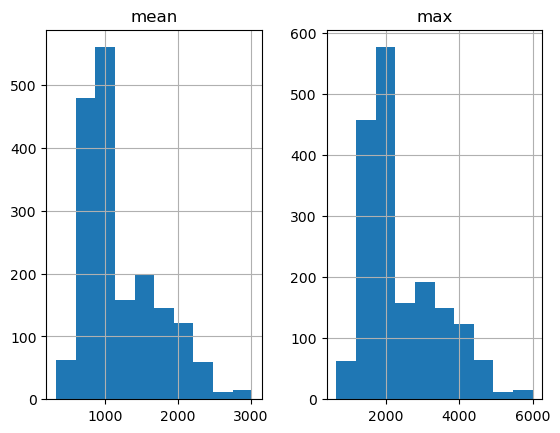

In [318]:
df.groupby(['subject', 'session', 'trial_num'])['time_within_trial'].describe()[['mean', 'max']].hist()

It seems that trials last up to 6000 milliseconds or so.

-----------------

Compare this plot when the missing value is removed, or when it is not removed.

In [319]:
# df.loc[df['time_within_trial'] > 6000].groupby(['subject', 'session', 'gesture', 'trial_num'])['time_within_trial'].max()

Series([], Name: time_within_trial, dtype: int64)

We can see now that we have a lot of `unmarked-data` epochs. They usually have longer duration than the marked epochs.

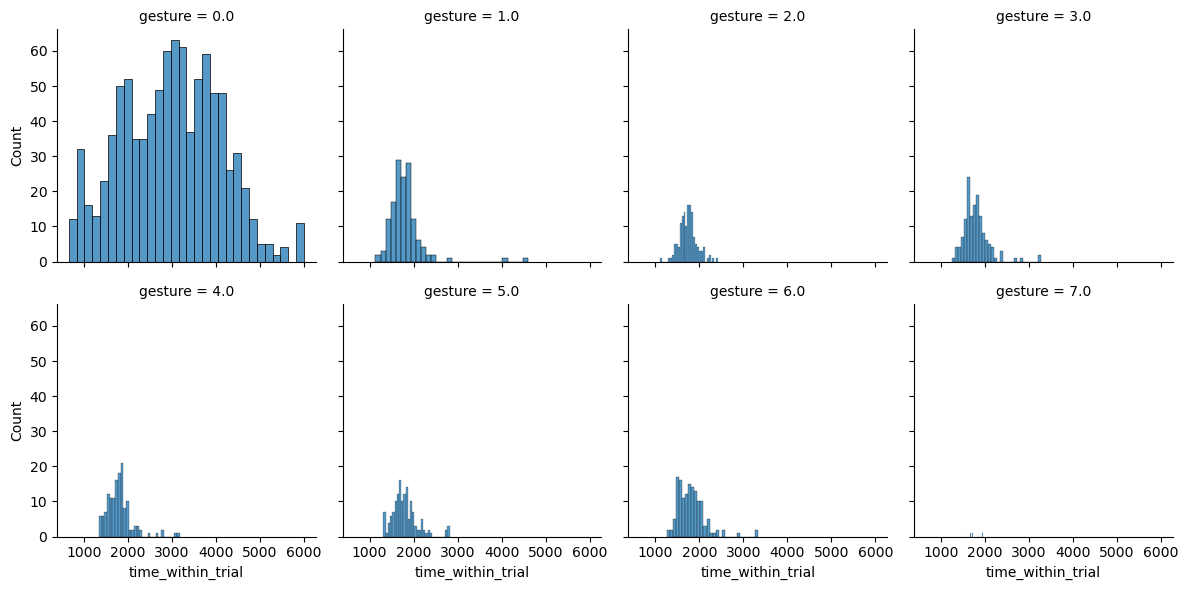

In [325]:
sns.FacetGrid(col='gesture', col_wrap=4, data=df.groupby(['subject', 'session', 'trial_num', 'gesture']
                                                         )['time_within_trial'].max().reset_index()).map(
    sns.histplot, 'time_within_trial', bins=30)

#### What is the sampling frequency of data?

To get the sampling frqeuency, we can divide the duration of each trial by the number of samples in it.

In [326]:
trial_duration_data = df.groupby(['subject', 'session', 'trial_num'])[
    'time_within_trial'].agg(['max', 'count']).rename({'count': 'numof_samples'}, axis=1).reset_index()

In [327]:
trial_duration_data['sampling_frequency'] = (trial_duration_data['max'] /
    trial_duration_data['numof_samples']).round(2)
trial_duration_data.head()

,subject,session,trial_num,max,numof_samples,sampling_frequency
0,01,1,0,2396,2287,1.05
1,01,1,1,2180,2115,1.03
2,01,1,2,2079,2022,1.03
3,01,1,3,1846,1794,1.03
4,01,1,4,4456,4316,1.03


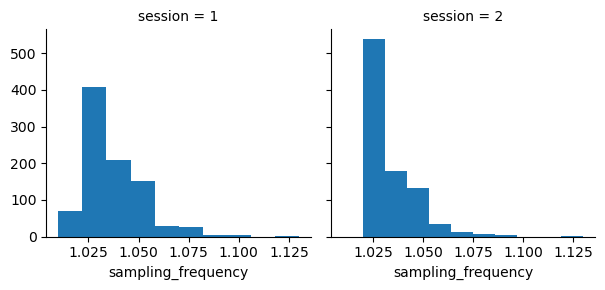

In [328]:
g = sns.FacetGrid(trial_duration_data, col='session', col_wrap=3)
g.map(plt.hist, 'sampling_frequency')

It seems that the sampling frequency is not constant, but most values are around 1MS (i.e., 1000Hz - as expected from the paper).

### General tidying

Subject and session are represented as strings, but they should be integers

In [331]:
df.dtypes.tail()

subject                object
session                object
trial_num               int32
time_within_trial       int64
sampling_frequency    float64
dtype: object

In [332]:
df[['subject', 'session', 'gesture']] = df[['subject', 'session', 'gesture']].astype(int)

#### Odd and missing gesture information

Some subjects have more than 7 different gestures (extended palm gesture was not recorded for most).

In [333]:
df.groupby('subject')['gesture'].nunique().value_counts()

gesture
7    34
8     2
Name: count, dtype: int64

We can either remove the subjects, or remove the periods with the extra gesture, either way, here are their subject and session IDs.

In [334]:
more_than_seven_gestures = df.groupby(['subject', 'session'])['gesture'].nunique().reset_index(
    ).rename({'gesture': 'numof_classes'}, axis=1).query(
    'numof_classes > 7')

more_than_seven_gestures

,subject,session,numof_classes
20,11,1,8
21,11,2,8
58,30,1,8
59,30,2,8


Here we select to remove these periods from the data.

In [335]:
df = df.loc[df['gesture'] != 7]

We can visualize the allocation of gestures throughout sessions.

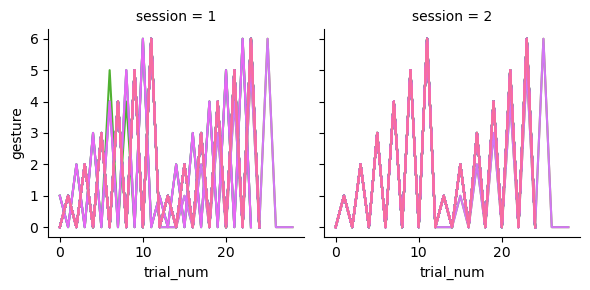

In [348]:
g = sns.FacetGrid(df.groupby(['subject', 'session', 'trial_num', 'gesture'])[
                  'time_within_trial'].first().reset_index(), col='session', col_wrap=2, hue='subject')
g.map(sns.lineplot, 'trial_num', 'gesture')

We can see that almost all subjects performed the gestures in the same order - 0-1-0-2 and so on, and then repeated all gestures again (within that session). This is not ideal of course, as a confounding factor - of the order of the gestures is introduced. This might for example interfere with fatigure when performing gestures number 6 and 7.

One last thing we can do when tidying the dataset it to further segment each trial into periods of 200MS. This is the period used in the paper to calculate the features.

In [360]:
df['epoch'] = (df['time_within_trial'] // 200)

In [363]:
df.loc[(df['subject'] == 1) & (df['session'] == 1)].groupby(['trial_num', 'epoch']).first().reset_index()[['time', 'time_within_trial', 'epoch']]

,time,time_within_trial,epoch
0,1,0,0
1,201,200,1
2,401,400,2
3,601,600,3
4,801,800,4
...,...,...,...
334,64718,800,4
335,64918,1000,5
336,65118,1200,6
337,65318,1400,7


## EMG data

We can finally look at the EMG data. It is specified in microvolts (uV), which is 1-millionth of a volt.

We can change the units to millivolts (mV), which is 1-thousandth of a volt, for easier reading.

In [ ]:
df.filter(regex='channel\d$') = df.filter(regex='channel\d$') / 1000

In [367]:
df.filter(regex='channel\d$').describe()

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
count,4.200995e+06,4.200995e+06,4.200995e+06,4.200995e+06,4.200995e+06,4.200995e+06,4.200995e+06,4.200995e+06
mean,-7.932773e-06,-9.411849e-06,-9.543042e-06,-9.630714e-06,-1.603890e-05,-1.085445e-05,-9.372503e-06,-9.653930e-06
std,1.626363e-04,1.196544e-04,1.245621e-04,2.263657e-04,2.723243e-04,2.151316e-04,1.530369e-04,1.717218e-04
min,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03
25%,-3.000000e-05,-4.000000e-05,-4.000000e-05,-6.000000e-05,-8.000000e-05,-6.000000e-05,-4.000000e-05,-3.000000e-05
50%,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05
75%,2.000000e-05,2.000000e-05,3.000000e-05,4.000000e-05,5.000000e-05,3.000000e-05,2.000000e-05,1.000000e-05
max,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03


## Feature engineering

Common EMG features are root-mean-square and mean-absolute-value, calculated on each value. Here they are calculated per trial, we can also calculate them per period (200MS) within each trial.

In [364]:
# Prepare the arguments for the aggregation - a dictionary of the new column names, and the functions to apply
agg_args = {k: [root_mean_square, mean_abs_val] for k in df.filter(regex='channel\d$').columns}

aggregated_df = df.groupby(['subject', 'session', 'trial_num', 'epoch'])[
    list(agg_args.keys())].agg(
    agg_args)

In [365]:
aggregated_df.head()

channel1                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000015     0.000012  \
                          1             0.000014     0.000009   
                          2             0.000015     0.000014   
                          3             0.000019     0.000015   
                          4             0.000020     0.000015   

                                        channel2                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000034     0.000023  \
                          1             0.000024     0.000017   
                          2             0.000025     0.000015   
                          3             0.000028     0.000022   
                          4             0.000023     0.000018   

                                        channel3                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000040     0.000032  \
                          1             0.000023     0.000020   
                          2             0.000029     0.000026   
                          3             0.000021     0.000019   
                          4             0.000023     0.000014   

                                        channel4                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000042     0.000033  \
                          1             0.000022     0.000017   
                          2             0.000021     0.000019   
                          3             0.000019     0.000015   
                          4             0.000024     0.000019   

                                        channel5                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000017     0.000015  \
                          1             0.000016     0.000011   
                          2             0.000015     0.000012   
                          3             0.000016     0.000010   
                          4             0.000016     0.000012   

                                        channel6                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000015     0.000013  \
                          1             0.000014     0.000012   
                          2             0.000012     0.000009   
                          3             0.000017     0.000014   
                          4             0.000013     0.000010   

                                        channel7                
                                root_mean_square mean_abs_val   
subject session trial_num epoch                                 
1       1       0         0             0.000017     0.000013  \
                          1             0.000012     0.000009   
                          2             0.000014     0.000012   
                          3             0.000015     0.000011   
                          4             0.000015     0.000012   

                                        channel8               
                                root_mean_square mean_abs_val  
subject session trial_num epoch                                
1       1       0         0             0.000014     0.000010  
                          1             0.000012     0.000009  
                          2             0.000015     0.000012  
         

Accessing the Multindex

In [346]:
aggregated_df.head().loc[(1, 1, 0), 'channel1']

root_mean_square    0.000015
mean_abs_val        0.000011
Name: (1, 1, 0), dtype: float64

## Save the data

To be used on further lessons - plotting, modelling, etc.

The file is quite large, so we will save it as a zipped dataframe (can still be read with `pd.read_csv`).

In [ ]:
df.to_csv('../output/output-data/emg-data-clean.zip ', index=False)